# Classification of MRI brain images into healthy or pathological


This is a machine learning task that classifies MRI Scan images as healthy or pathological.

### DATA
The data for this project was obtained from this repository: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection

### FILE STRUCTURE.
Create a folder named 'data' in the same directory as this file (the code file) \
Inside the 'data' folder, create another folder named 'brain_tumor_dataset' \
Place in this folder the 'no' and 'yes' data folders retrieved from the data site.

### Import module

In [1]:
#Import the necessary libraries first

import tensorflow as tf
import os
import itertools
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
import shutil
import glob
import re

In [2]:
#  ASSIGN VARIABLES TO THE PATHS OF THE DATA FILES
data = './data/brain_mri_dataset'
No_brain_tumor = './data/brain_mri_dataset/no/'
Yes_brain_tumor = './data/brain_mri_dataset/yes/'

## Data Augmentation
To add up to the images in the dataset, we'll generate some more images from the given set to augment the available data

In [3]:
# CREATE A FUNCTION TO GENERATE AN ADDITION OF 5 IMAGES FOR EACH IMAGE IN THE DIRECTORY
def generate_images(filepath, num_images_to_consider, num_images_to_generate, gen_images_folder_path):
    total_gen_images = []
    images_array = []
    # Initializing The ImageDataGenerator function to generate additional images.
    gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                        shear_range=0.15, zoom_range=0.1, channel_shift_range=10, horizontal_flip=True)
    # Loop through the number of images in the given directory
    for image in os.listdir(filepath)[0:num_images_to_consider]:
        # List to hold all the generated images for a single image file
        gen_images = []
        # Obtain Image path
        image_path = filepath + image
        # Obtain image array
        new_image = np.expand_dims(img_to_array(plt.imread(image_path)), 0)
        # Generate batches of augmented images from this image
        aug_iter = gen.flow(new_image, batch_size=1, save_to_dir=gen_images_folder_path)
        
        total = 0
        for image_gen in aug_iter:
            gen_images.append(image_gen)
            total += 1
            
            if total == num_images_to_generate:
                break
        
        # Append the array object of the file to the images array
        images_array.append(new_image)
        print(f'Total number of generated images for {image}: ', len(gen_images))
        
        total_gen_images.append(gen_images)
    print('Total number of images generated altogether: ', len(os.listdir(gen_images_folder_path)))
        
    

In [4]:
# CODE TO GENERATE FIVE IMAGES EACH OF THE NINETY-EIGHT IMAGES IN THE 'NO' DIRECTORY IN ADDITION TO THE EXISTING ONES
generate_images('./data/brain_mri_dataset/no/', 98, 5, 'data/brain_mri_dataset/no/')

Total number of generated images for 1 no.jpeg:  5
Total number of generated images for 10 no.jpg:  5
Total number of generated images for 11 no.jpg:  5
Total number of generated images for 12 no.jpg:  5
Total number of generated images for 13 no.jpg:  5
Total number of generated images for 14 no.jpg:  5
Total number of generated images for 15 no.jpg:  5
Total number of generated images for 17 no.jpg:  5
Total number of generated images for 18 no.jpg:  5
Total number of generated images for 19 no.jpg:  5
Total number of generated images for 2 no.jpeg:  5
Total number of generated images for 20 no.jpg:  5
Total number of generated images for 21 no.jpg:  5
Total number of generated images for 22 no.jpg:  5
Total number of generated images for 23 no.jpg:  5
Total number of generated images for 24 no.jpg:  5
Total number of generated images for 25 no.jpg:  5
Total number of generated images for 26 no.jpg:  5
Total number of generated images for 27 no.jpg:  5
Total number of generated image

In [5]:
# CODE TO GENERATE FIVE IMAGES EACH OF THE FIRST NINETY IMAGES IN THE 'YES' DIRECTORY IN ADDITION TO THE EXISTING ONES
generate_images('./data/brain_mri_dataset/yes/', 90, 5, 'data/brain_mri_dataset/yes/')

Total number of generated images for Y1.jpg:  5
Total number of generated images for Y10.jpg:  5
Total number of generated images for Y100.JPG:  5
Total number of generated images for Y101.jpg:  5
Total number of generated images for Y102.jpg:  5
Total number of generated images for Y103.jpg:  5
Total number of generated images for Y104.jpg:  5
Total number of generated images for Y105.jpg:  5
Total number of generated images for Y106.jpg:  5
Total number of generated images for Y107.jpg:  5
Total number of generated images for Y108.jpg:  5
Total number of generated images for Y109.JPG:  5
Total number of generated images for Y11.jpg:  5
Total number of generated images for Y111.JPG:  5
Total number of generated images for Y112.JPG:  5
Total number of generated images for Y113.JPG:  5
Total number of generated images for Y114.JPG:  5
Total number of generated images for Y115.JPG:  5
Total number of generated images for Y116.JPG:  5
Total number of generated images for Y117.JPG:  5
Tota

In [6]:
print('Number of images in the NO directory: ', len(os.listdir('./data/brain_mri_dataset/no/')))

Number of images in the NO directory:  580


In [7]:
print('Number of images in the YES directory: ', len(os.listdir('./data/brain_mri_dataset/yes/')))

Number of images in the YES directory:  596


A total of 1,176 images are now available for the model to train with as against the initial 253 images. This will help the model to generalize more on any given data.

## Creating a dataframe showing tumour class with corresponding filepath

In [8]:
# CREATE A FUNCTION FOR PUTTING TOGETHER ALL THE IMAGE FILES IN THE DATASET AND ASSIGN THEM LABELS

def filepaths_with_labels(No_brain_tumor_path, Yes_brain_tumor_path):
    # List of the paths to the two directories in the brain_tumor_dataset folder
    dirlist=[No_brain_tumor_path, Yes_brain_tumor_path]
    # ['brain_tumor_dataset/no/', 'brain_tumor_dataset/yes/']

    # Classes to be assigned to each of the path
    classes=['No', 'Yes']

    # A list to hold the filepath for each image in the dataset
    filepaths=[]

    # A list to hold the labels of each file in the brain_tumor_dataset path
    labels=[]
    for i,j in zip(dirlist, classes):
        ## print(i)
        # ./data/brain-tumor-dataset/no/
        # ./data/brain-tumor-dataset/yes/
        ## print(j)
        # No
        # Yes

        # A list of all images in both the 'No' class and the 'Yes' class
        filelist = os.listdir(i)
        ##print(filelist)
        ##print('\n')
        # os.listdir --> returns a list containing the names of the entries in the directory given by path.

        # Code to place the path of each file in the filelist into the filepath list.
        # 
        for f in filelist:
            filepath=os.path.join (i,f)
            # os.path.join('brain_tumor_dataset/no/','1 no.jpeg;)
            # brain_tumor_dataset/no/1 no.jpeg
            filepaths.append(filepath)
            # store the path into empty list called filepaths
            labels.append(j)

        # Print out the filepaths and the corressponding labels for each No/Yes data item
#         #print(filepaths)
#         #print('\n')
#         #print(labels)
#         #print('\n')

    # Finally show the filepaths and the corresponding labels.
    ##print ('filepaths: ', len(filepaths), '   labels: ', len(labels))
    return filepaths, labels


In [9]:
filepaths, labels = filepaths_with_labels(No_brain_tumor, Yes_brain_tumor)

In [10]:
filepaths

['./data/brain_tumor_dataset/no/1 no.jpeg',
 './data/brain_tumor_dataset/no/10 no.jpg',
 './data/brain_tumor_dataset/no/11 no.jpg',
 './data/brain_tumor_dataset/no/12 no.jpg',
 './data/brain_tumor_dataset/no/13 no.jpg',
 './data/brain_tumor_dataset/no/14 no.jpg',
 './data/brain_tumor_dataset/no/15 no.jpg',
 './data/brain_tumor_dataset/no/17 no.jpg',
 './data/brain_tumor_dataset/no/18 no.jpg',
 './data/brain_tumor_dataset/no/19 no.jpg',
 './data/brain_tumor_dataset/no/2 no.jpeg',
 './data/brain_tumor_dataset/no/20 no.jpg',
 './data/brain_tumor_dataset/no/21 no.jpg',
 './data/brain_tumor_dataset/no/22 no.jpg',
 './data/brain_tumor_dataset/no/23 no.jpg',
 './data/brain_tumor_dataset/no/24 no.jpg',
 './data/brain_tumor_dataset/no/25 no.jpg',
 './data/brain_tumor_dataset/no/26 no.jpg',
 './data/brain_tumor_dataset/no/27 no.jpg',
 './data/brain_tumor_dataset/no/28 no.jpg',
 './data/brain_tumor_dataset/no/29 no.jpg',
 './data/brain_tumor_dataset/no/3 no.jpg',
 './data/brain_tumor_dataset/no/3

In [11]:
labels

['No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',

### CONVERT EACH FILEPATH AND THE CORRESPONDING LABEL INTO A PANDAS DATAFRAME

In [12]:
# 
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
# df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
# df.head()
df

,filepaths,labels
0,./data/brain_tumor_dataset/no/1 no.jpeg,No
1,./data/brain_tumor_dataset/no/10 no.jpg,No
2,./data/brain_tumor_dataset/no/11 no.jpg,No
3,./data/brain_tumor_dataset/no/12 no.jpg,No
4,./data/brain_tumor_dataset/no/13 no.jpg,No
...,...,...
1171,./data/brain_tumor_dataset/yes/_0_9858.png,Yes
1172,./data/brain_tumor_dataset/yes/_0_987.png,Yes
1173,./data/brain_tumor_dataset/yes/_0_9873.png,Yes
1174,./data/brain_tumor_dataset/yes/_0_9877.png,Yes


In [13]:
#Get a binary representation of the labels in the dataframe.
df['labels']=pd.get_dummies(df['labels'])

In [14]:
# Show resulting dataframe
df

,filepaths,labels
0,./data/brain_tumor_dataset/no/1 no.jpeg,1
1,./data/brain_tumor_dataset/no/10 no.jpg,1
2,./data/brain_tumor_dataset/no/11 no.jpg,1
3,./data/brain_tumor_dataset/no/12 no.jpg,1
4,./data/brain_tumor_dataset/no/13 no.jpg,1
...,...,...
1171,./data/brain_tumor_dataset/yes/_0_9858.png,0
1172,./data/brain_tumor_dataset/yes/_0_987.png,0
1173,./data/brain_tumor_dataset/yes/_0_9873.png,0
1174,./data/brain_tumor_dataset/yes/_0_9877.png,0


## Visualize brain tumour images

<Figure size 288x288 with 0 Axes>

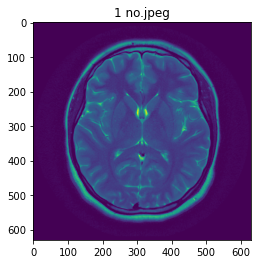

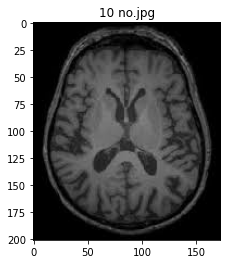

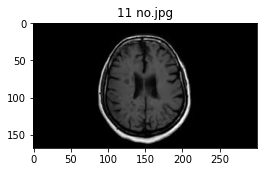

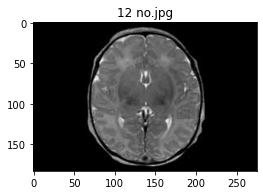

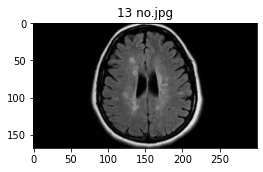

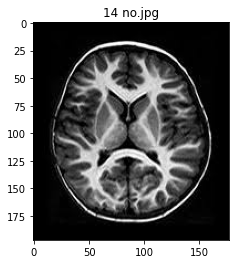

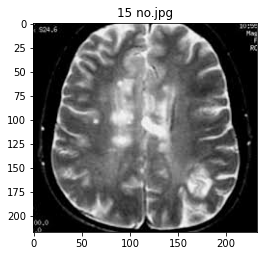

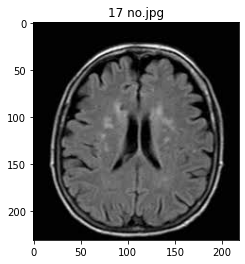

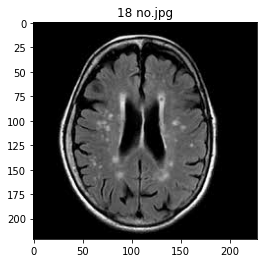

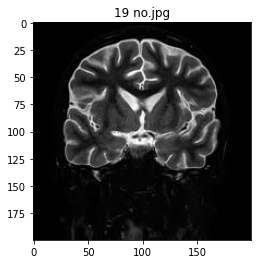

In [15]:
plt.figure(figsize=(4,4))
# View first 10 images
for i in range(0,10):
    fig, ax = plt.subplots(figsize=(4,4))
    img = mpimg.imread(df['filepaths'][i])
    img_name = re.sub(r'^\D+','',df['filepaths'][i])
    ax.imshow(img)
    ax.set_title(img_name)

## Since each image has different size, we need to resize them into same size

In [16]:
# FIRST CREATE A FUNCTION TO DETERMINE THE AVERAGE WIDTH AND HEIGHT OF ALL THE IMAGES IN THE DATASET
def average_width_and_height(dataframe):
    # Using the Pillow library to handle the task
    from PIL import Image
    # Empty list to take the widths of all the images in the dataframe
    widths = []
    # Empty list to take the heights of all the images in the dataframe
    heights = []

    # Looping over all the images in the dataframe and appending their widths and heights to the empty lists
    for idx, row in dataframe.iterrows():
        path = row['filepaths']
        # print(path)
        im = Image.open(path)
        # print(im.size)
        width, height = im.size
        widths.append(width)
        heights.append(height)
    # Calculate the average width and height of the images
    avg_width = int(sum(widths) / len(widths))
    avg_height = int(sum(heights) / len(heights))
    print('Average width is: ',avg_width,' and Average Height is: ', avg_height)

In [17]:
average_width_and_height(df)

Average width is:  343  and Average Height is:  371


The average width is 343 and the average height is 371. Making the width and height equal makes it simpler to do transformations later. So we’ll resize images to 300x300.

In [18]:
# A FUNCTION TO RESIZE A SINGLE IMAGE
from tensorflow.keras.preprocessing.image import load_img

# Image Resize Function
def load_resize_color_image(path, size):
    # load image and resize to 300x300
    image = load_img(path,target_size=size)
    return image

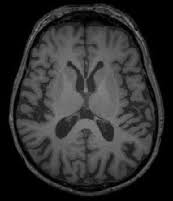

In [19]:
# LOADING THE IMAGE ORDINARILY
load_img('./data/brain_tumor_dataset/no/10 no.jpg')

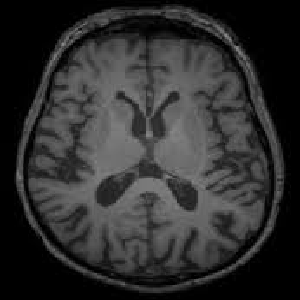

In [20]:
# AFTER APPLYIMG THE RESIZE FUNCTION TO THE SAME IMAGE
load_resize_color_image('./data/brain_tumor_dataset/no/10 no.jpg', (300,300))

### Resize all images and convert them to arrays

In [21]:
# CREATE A FUNCTION TO UNDERTAKE THIS TASK
def resize_and_convert_to_array(dataframe):
    # Empty list to hold the array of each image corresponding to a file path
    image_list = []
    # Empty list to hold the labels of each image item.
    cancer_list = []
    for idx, row in dataframe.iterrows():
        path = row['filepaths']
        cancer = row['labels']
        # print(path)
        # print(cancer)
        image = load_resize_color_image(path, (300, 300))
        # turn image to array
        image_array = img_to_array(image)   
        image_list.append(image_array)
        cancer_list.append(cancer)
    return image_list, cancer_list

In [22]:
# APPLY THE FUNCTION TO THE DATAFRAME OF IMAGE PATHS AND RETRIEVE THE LIST OF IMAGE ARRAYS AND THEIR CORRESPONDING LABELS
image_list, cancer_list = resize_and_convert_to_array(df)

In [23]:
print(image_list[0:5])

[array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32), array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [

In [24]:
print(cancer_list[0:5])

[1, 1, 1, 1, 1]


## Shuffle the image and label

In [43]:
from sklearn.utils import shuffle
image_list, cancer_list = shuffle(image_list, cancer_list)

## Define our X, y for train-test-split

In [44]:
X_data = np.array(image_list)
y_data = np.array(cancer_list)

In [45]:
print(X_data.shape)
print(y_data.shape)

(1176, 300, 300, 3)
(1176,)


## Split into training set and testing set

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.8, random_state=0)

In [47]:
print(X_train.shape)
print(y_train.shape)

(940, 300, 300, 3)
(940,)


In [48]:
X_train = X_train/255
X_test = X_test/255

In [49]:
X_train

array([[[[0.06666667, 0.06666667, 0.06666667],
         [0.06666667, 0.06666667, 0.06666667],
         [0.06666667, 0.06666667, 0.06666667],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.06666667, 0.06666667, 0.06666667],
         [0.06666667, 0.06666667, 0.06666667],
         [0.06666667, 0.06666667, 0.06666667],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        [[0.06666667, 0.06666667, 0.06666667],
         [0.06666667, 0.06666667, 0.06666667],
         [0.06666667, 0.06666667, 0.06666667],
         ...,
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079],
         [0.10196079, 0.10196079, 0.10196079]],

        ...,

        [[1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]

In [50]:
print(X_test.shape)
print(y_test.shape)

(236, 300, 300, 3)
(236,)


## Building CNN Model Architecture

In [51]:
epochs = 10
batch_size = 10
input_shape = (300,300,3)

In [52]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# ANN structure
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 78400)            

In [54]:
#   define compile to minimize categorical loss, use ada delta optimized, and optimize to maximizing accuracy
model.compile(loss="binary_crossentropy",
              optimizer='Adam',
              metrics=['accuracy'])

#   Train the model and test/validate the model with the test data after each cycle (epoch) through the training data
#   Return history of loss and accuracy for each epoch
hist = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.1)

Epoch 1/10
85/85 [==============================] - 93s 1s/step - loss: 0.5996 - accuracy: 0.6749 - val_loss: 0.5048 - val_accuracy: 0.7340
Epoch 2/10
85/85 [==============================] - 94s 1s/step - loss: 0.5242 - accuracy: 0.7447 - val_loss: 0.4938 - val_accuracy: 0.7872
Epoch 3/10
85/85 [==============================] - 96s 1s/step - loss: 0.4458 - accuracy: 0.7920 - val_loss: 0.4173 - val_accuracy: 0.8404
Epoch 4/10
85/85 [==============================] - 93s 1s/step - loss: 0.3794 - accuracy: 0.8239 - val_loss: 0.4181 - val_accuracy: 0.8085
Epoch 5/10
85/85 [==============================] - 92s 1s/step - loss: 0.2487 - accuracy: 0.8995 - val_loss: 0.4171 - val_accuracy: 0.8298
Epoch 6/10
85/85 [==============================] - 92s 1s/step - loss: 0.1483 - accuracy: 0.9397 - val_loss: 0.4063 - val_accuracy: 0.8191
Epoch 7/10
85/85 [==============================] - 93s 1s/step - loss: 0.0841 - accuracy: 0.9610 - val_loss: 0.9557 - val_accuracy: 0.7660
Epoch 8/10
85/85 [==

Test loss: 1.6332517862319946
Test accuracy: 0.7711864113807678


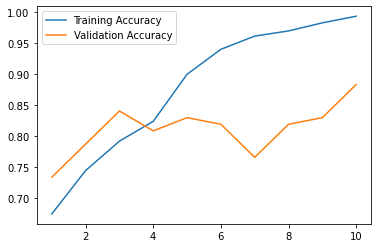

In [72]:
# PLOTTING DATA TO SHOW THE RELATIONSHIPS IN TRAINING AND VALIDATION DATA
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

### Running Predictions on the test data

In [56]:
# Making a prediction on the test set
predictions = model.predict(x=X_test, verbose=0)

In [57]:
# Rounding the probabilities to zero and one
np.round(predictions)

array([[0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],

## Visualizing The Performance of the Model

In [58]:
# Creating a confusion matrix to view the performance of the model on the test set
cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(predictions, axis=1))

In [59]:
# Function to plot a confusion Matrix
# Directly copied from the Scikit Learn website
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[124   0]
 [112   0]]


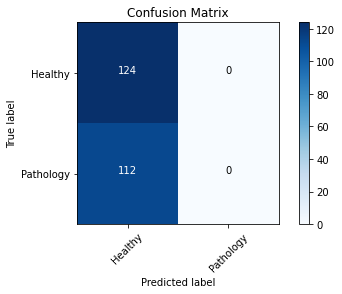

In [60]:
# Defining the labels of the confusion Matrix and plotting it
cm_plot_labels = ['Healthy', 'Pathology']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## Run a Prediction on New Image

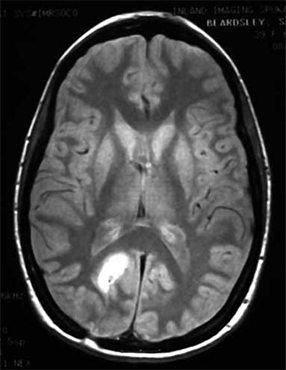

In [61]:
# THIS IS A RANDOM IMAGE FROM THE INTERNET OF A PATHOLOGIC MRI SCAN (BRAIN TUMOR)
load_img('test_image_yes.png')

In [65]:
# A function to take new image, preprocess the image and run a prediction on the image. 
# The function returns the result of the prediction
def new_prediction(image, size):
    # Load and resize image file
    image = load_resize_color_image(image, size)
    # turn image to array
    image_array = img_to_array(image)
    # Normalize each image pixel to a standard range within 0 and 255
    new_image_array = image_array / 255
    # Create a batch of one image
    new_img_array_batch = np.expand_dims(new_image_array, axis=0)
    # Run the prediction
    pred = model.predict(new_img_array_batch)
    return pred

In [68]:
# APPLY THE PREDICTION FUNCTION ON THE NEW IMAGE
new_pred = new_prediction('test2_yes.png', (300, 300))

# ROUND THE PREDICTION TO ASCERTAIN THE LABEL OF THE IMAGE
np.round(new_pred)

array([[1.]], dtype=float32)

In [69]:
# APPLY THE PREDICTION FUNCTION ON THE NEW IMAGE
new_pred = new_prediction('test 3 no.jpg', (300, 300))

# ROUND THE PREDICTION TO ASCERTAIN THE LABEL OF THE IMAGE
np.round(new_pred)

array([[1.]], dtype=float32)

In [71]:
# APPLY THE PREDICTION FUNCTION ON THE NEW IMAGE
new_pred = new_prediction('test2_yes.png', (300, 300))

# ROUND THE PREDICTION TO ASCERTAIN THE LABEL OF THE IMAGE
np.round(new_pred)

array([[1.]], dtype=float32)

The prediction function has been tested on three random images taken from the internet.  Two of them are pathologic and one healthy. However, the model predicted all three images to be healthy. This may likely be due to overfitting from the large quantity of dataset.